# Processing the datasets

In [1]:
import numpy
import pandas
from matplotlib import pyplot
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
import scipy.stats

## Preprocessing

In [2]:
# Loading all datasets
internet = pandas.read_csv("Percentage of individuals using the Internet.csv")
infrastructure = pandas.read_csv("Quality of port infrastructure.csv")
gdp = pandas.read_csv("GDP Per Capita.csv", encoding='latin-1')

In [3]:
internet.head()

,Country or Area,Year,Value,Value Footnotes
0,Afghanistan,2014,6.390000,NaN
1,Afghanistan,2013,5.900000,NaN
2,Afghanistan,2012,5.454545,NaN
3,Afghanistan,2011,5.000000,NaN
4,Afghanistan,2010,4.000000,NaN


In [4]:
# Remove invalid countries (indicated by the "Value Footnotes" field)
internet = internet[internet["Value Footnotes"] != 2]

In [5]:
infrastructure.head()

,Country or Area,Year,Value,Value Footnotes
0,Albania,2017,4.10000,NaN
1,Albania,2016,4.20000,NaN
2,Albania,2015,4.15121,NaN
3,Albania,2014,3.70000,NaN
4,Albania,2013,3.50000,NaN


In [6]:
## Rename the columns
def rename_columns(dataframe):
    columns = dataframe.columns.tolist()
    new_col = []
    for x in columns:
        new_col.append(dataframe[x][0])
    dataframe.columns = new_col

In [7]:
internet = internet.rename(index=str, columns={"Value": "Internet"})
internet.head()

,Country or Area,Year,Internet,Value Footnotes
0,Afghanistan,2014,6.390000,NaN
1,Afghanistan,2013,5.900000,NaN
2,Afghanistan,2012,5.454545,NaN
3,Afghanistan,2011,5.000000,NaN
4,Afghanistan,2010,4.000000,NaN


In [8]:
infrastructure = infrastructure.rename(index=str, columns={"Value": "Infrastructure"})
infrastructure.head()

,Country or Area,Year,Infrastructure,Value Footnotes
0,Albania,2017,4.10000,NaN
1,Albania,2016,4.20000,NaN
2,Albania,2015,4.15121,NaN
3,Albania,2014,3.70000,NaN
4,Albania,2013,3.50000,NaN


In [9]:
gdp.head()

,Country or Area,Year,Value
0,Afghanistan,2017,618.989990
1,Afghanistan,2016,583.883061
2,Afghanistan,2015,610.854545
3,Afghanistan,2014,651.158426
4,Afghanistan,2013,681.034215


In [10]:
# Drop unnecessary columns
internet = internet.drop(['Value Footnotes'], axis=1)
infrastructure = infrastructure.drop(['Value Footnotes'], axis=1)
internet.head()

,Country or Area,Year,Internet
0,Afghanistan,2014,6.390000
1,Afghanistan,2013,5.900000
2,Afghanistan,2012,5.454545
3,Afghanistan,2011,5.000000
4,Afghanistan,2010,4.000000


In [11]:
# Drop any NaN entries
internet.dropna()
infrastructure.dropna()
gdp.dropna()
infrastructure["Year"] = [int(x) for x in infrastructure["Year"]]
infrastructure = infrastructure[infrastructure['Infrastructure'].notnull()]
internet = internet[internet['Internet'].notnull()]

# Make sure that there's no more nan fields
internet.isnull().sum()
infrastructure.isnull().sum()

Country or Area    0
Year               0
Infrastructure     0
dtype: int64

In [12]:
# Find shared year and country
internet_years = list(Counter(internet["Year"]).keys())
infrastructure_years = list(Counter(infrastructure["Year"]).keys())
year_intersection = list(set(internet_years) & set(infrastructure_years))

internet_area = list(Counter(internet["Country or Area"]).keys())
infrastructure_area = list(Counter(infrastructure["Country or Area"]).keys())
area_intersection = list(set(internet_area) & set(infrastructure_area))

In [13]:
# Filter out entries of shared year and country
# filtering years
internet = internet[internet["Year"].isin(year_intersection)]
infrastructure = infrastructure[infrastructure["Year"].isin(year_intersection)]
gdp = gdp[gdp["Year"].isin(year_intersection)]

# filter country based on years
c_infrastructure = Counter(infrastructure["Country or Area"])
c_internet = Counter(internet["Country or Area"])
c_gdp = Counter(gdp["Country or Area"])
area_intersection = [x for x in area_intersection if c_infrastructure[x] == 8 & c_internet[x] == 8 & c_gdp[x] == 8]
internet = internet[internet["Country or Area"].isin(area_intersection)]
infrastructure = infrastructure[infrastructure["Country or Area"].isin(area_intersection)]
gdp = gdp[gdp["Country or Area"].isin(area_intersection)]

print("There are {:} country's records in {:} years in common in datasets \"internet\", \"infrastructure\", and \"gdp\"."
      .format(len(area_intersection), len(year_intersection)))

There are 103 country's records in 8 years in common in datasets "internet", "infrastructure", and "gdp".


## Data aggregation and separation

### Aggregation

In [14]:
# Make sure that "internet" and "infrastructure" have the same shape
infrastructure.head()

,Country or Area,Year,Infrastructure
3,Albania,2014,3.700000
4,Albania,2013,3.500000
5,Albania,2012,3.700000
6,Albania,2011,3.900000
7,Albania,2010,3.540775


In [15]:
internet.head()

,Country or Area,Year,Internet
15,Albania,2014,60.100000
16,Albania,2013,57.200000
17,Albania,2012,54.655959
18,Albania,2011,49.000000
19,Albania,2010,45.000000


In [16]:
# Join infrastructure and internet
infrastructure = infrastructure.reset_index()
internet = internet.reset_index()
summary = pandas.concat([infrastructure,pandas.DataFrame(internet["Internet"])], axis=1)
summary.head()

,index,Country or Area,Year,Infrastructure,Internet
0,3,Albania,2014,3.700000,60.100000
1,4,Albania,2013,3.500000,57.200000
2,5,Albania,2012,3.700000,54.655959
3,6,Albania,2011,3.900000,49.000000
4,7,Albania,2010,3.540775,45.000000


In [17]:
summary["multiplied"] = numpy.multiply(infrastructure["Infrastructure"], internet["Internet"])
summary["added"] = numpy.add(infrastructure["Infrastructure"], internet["Internet"])
summary.head()

,index,Country or Area,Year,Infrastructure,Internet,multiplied,added
0,3,Albania,2014,3.700000,60.100000,222.370000,63.800000
1,4,Albania,2013,3.500000,57.200000,200.200000,60.700000
2,5,Albania,2012,3.700000,54.655959,202.227048,58.355959
3,6,Albania,2011,3.900000,49.000000,191.100000,52.900000
4,7,Albania,2010,3.540775,45.000000,159.334854,48.540775


In [18]:
# Group each country's data by Area and then by Year
groups = summary.groupby(["Country or Area", "Year"]).mean()
mean_infrastructure_groups = groups.groupby(level='Country or Area').mean()
inf_groups_mul = mean_infrastructure_groups["multiplied"]
inf_groups_add = mean_infrastructure_groups["added"]
print(inf_groups_mul.head())

Country or Area
Albania      149.656191
Algeria       39.156784
Armenia       73.797611
Australia    381.699534
Austria      366.572950
Name: multiplied, dtype: float64


In [19]:
groups2 = gdp.groupby(["Country or Area", "Year"]).mean()
mean_gdp_groups = groups2.groupby(level='Country or Area').mean()
gdp_groups = mean_gdp_groups["Value"]
print(gdp_groups.head())

Country or Area
Albania       4185.980190
Algeria       4888.470479
Armenia       3691.610467
Australia    58594.062930
Austria      49142.088741
Name: Value, dtype: float64


### Split the data by year

In [20]:
# list of each year
print(year_intersection)

[2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014]


In [21]:
def filter_year(df): 
    lst = []
    for year in year_intersection:
        lst.append(df.loc[df['Year'] == year])
    return lst

In [22]:
sum_years_lst = filter_year(summary)
sum_years_lst[0].head()

,index,Country or Area,Year,Infrastructure,Internet,multiplied,added
7,10,Albania,2007,2.072166,15.036115,31.157331,17.108282
15,21,Algeria,2007,3.270766,9.451191,30.912631,12.721956
23,58,Armenia,2007,2.815789,6.021253,16.954582,8.837043
31,69,Australia,2007,5.052648,69.450000,350.906385,74.502648
39,80,Austria,2007,4.970000,69.370000,344.768900,74.340000


In [23]:
gdp_years_lst = filter_year(gdp)
gdp_years_lst[0].head()

,Country or Area,Year,Value
58,Albania,2007,3530.969114
106,Algeria,2007,3935.183362
394,Armenia,2007,3347.296067
470,Australia,2007,46967.891730
518,Austria,2007,46761.506621


# Plotting the data

## Kmeans

In [24]:
# Trying to find if KMeans can come up with some reasonable clusters
def km(cluster, pairs, xlabel, ylabel, title):
    kmeans = KMeans(cluster)
    kmeans.fit(pairs)
    y_kmeans = kmeans.predict(pairs)
    y = [tup[1] for tup in pairs]
    x = [tup[0] for tup in pairs]
    pyplot.scatter(x, y, c=y_kmeans, s=50, cmap='viridis')
    pyplot.title(title)
    pyplot.xlabel(xlabel)
    pyplot.ylabel(ylabel)
    pyplot.show()

### Kmeans on aggregated data

In [25]:
# Applying Kmeans to (Infrastructure * Internet, GDP) and (Infrastructure + Internet, GDP)
infra_pairs_mul = list(zip(summary["multiplied"], gdp["Value"]))
infra_pairs_add = list(zip(summary["added"], gdp["Value"]))
print(infra_pairs_mul[:5])

[(222.37, 4529.01715429799), (200.20000000000002, 4376.970548507779), (202.227048448, 4219.04628955175), (191.1, 4404.638035262929), (159.33485358, 4056.0608341834495)]


In [26]:
# Applying Kmeans to aggregated datasets
mean_pairs_mul = list(zip(inf_groups_mul, gdp_groups))
mean_pairs_add = list(zip(inf_groups_add, gdp_groups))
print(mean_pairs_mul[:5])

[(149.65619073106313, 4185.980190278192), (39.15678354773006, 4888.47047943992), (73.79761132729492, 3691.6104668059925), (381.6995343746713, 58594.06292951735), (366.57295018896, 49142.08874076147)]


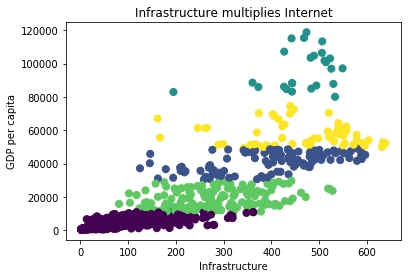

In [27]:
km(5, infra_pairs_mul, "Infrastructure", "GDP per capita", "Infrastructure multiplies Internet")

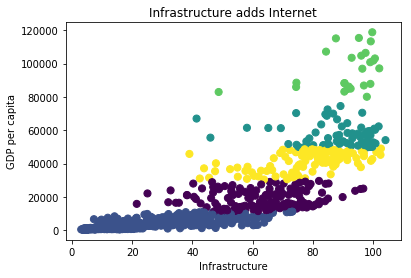

In [28]:
km(5, infra_pairs_add, "Infrastructure", "GDP per capita", "Infrastructure adds Internet")

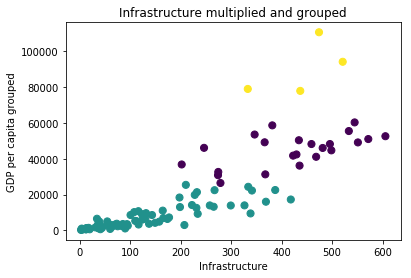

In [29]:
km(3, mean_pairs_mul, "Infrastructure", "GDP per capita grouped", "Infrastructure multiplied and grouped")

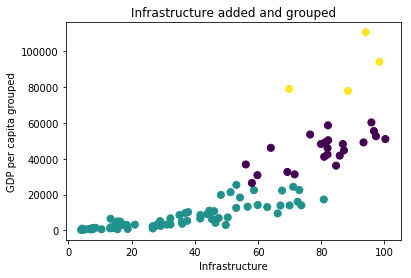

In [30]:
km(3, mean_pairs_add, "Infrastructure", "GDP per capita grouped", "Infrastructure added and grouped")

### Kmeans on data split by year

In [31]:
# Create a list of dataframes splitted by year, [field] is either [multiplied] or [added]
def split_pairs_lst(field):
    split_pairs_lst = []
    for i in range(0,8):
        split_pairs_lst.append(list(zip(sum_years_lst[i][field], gdp_years_lst[i]["Value"])))
    return split_pairs_lst

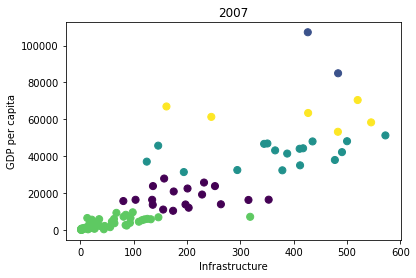

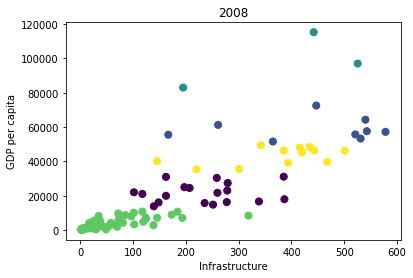

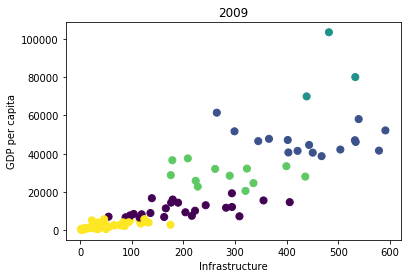

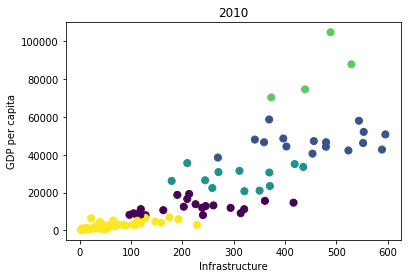

In [32]:
# Plot the progession of the relationship by time
split_pairs_lst_mul = split_pairs_lst("multiplied")
for i in range(0,4): # to make sure the plots don't get folded
    year = i + 2007
    km(5, split_pairs_lst_mul[i], "Infrastructure", "GDP per capita", str(year))

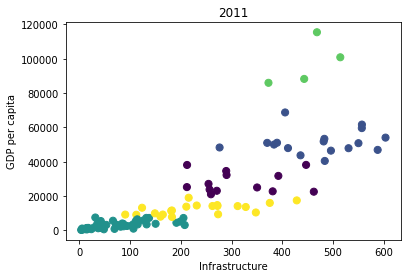

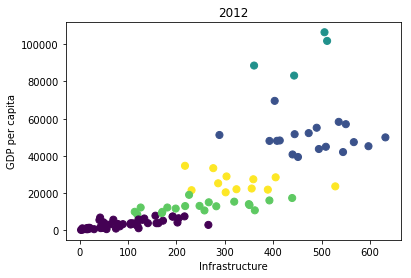

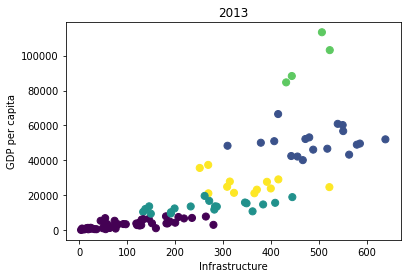

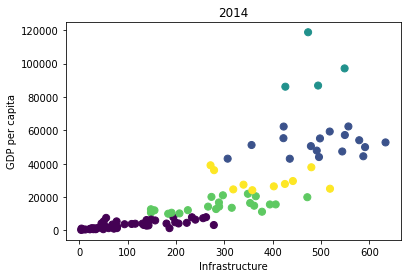

In [33]:
split_pairs_lst_mul = split_pairs_lst("multiplied")
for i in range(4,8):
    year = i + 2007
    km(5, split_pairs_lst_mul[i], "Infrastructure", "GDP per capita", str(year))

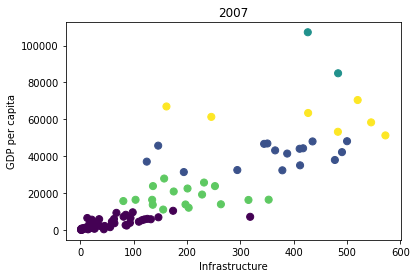

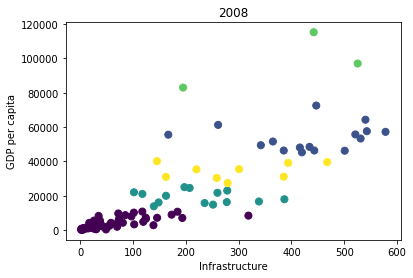

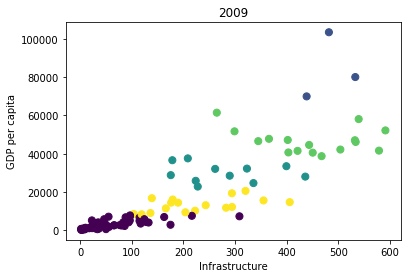

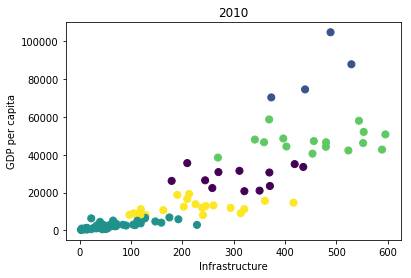

In [34]:
# Plot the progession of the relationship by time, again with (infrastructure + internet, GDP)
split_pairs_lst_add = split_pairs_lst("added")
for i in range(0,4):
    year = i + 2007
    km(5, split_pairs_lst_mul[i], "Infrastructure", "GDP per capita", str(year))

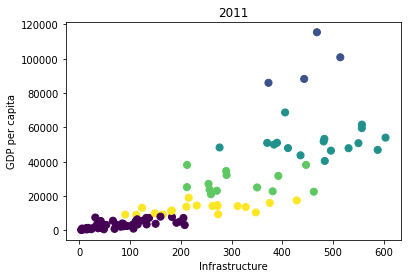

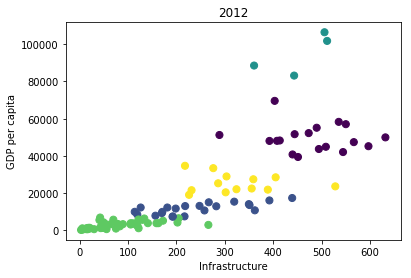

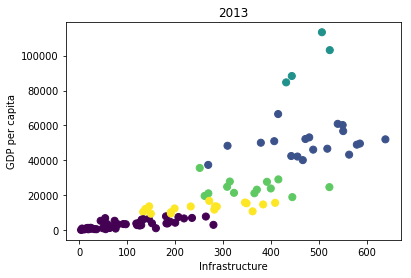

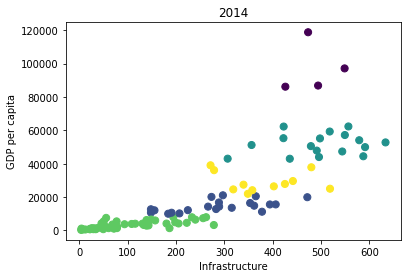

In [35]:
split_pairs_lst_add = split_pairs_lst("added")
for i in range(4,8):
    year = i + 2007
    km(5, split_pairs_lst_mul[i], "Infrastructure", "GDP per capita", str(year))

## Linear Regression

In [36]:
# Plot a linear regression on the datasets
def predict(x, slope, intercept):
    return x * slope + intercept
def linear_reg(x, y, title):
    model = LinearRegression().fit(x,y)
    cov = numpy.cov(numpy.squeeze(x), numpy.squeeze(y))
    cov1 = cov[0,1] #(cov(X,Y)
    cov2 = cov[0,0] #var(X)
    cov3 = cov[1,1] #var(Y)
    slope = cov1/cov2
    intercept = model.intercept_[0]
    r = cov1/(numpy.sqrt(cov2)*numpy.sqrt(cov3))
    x_extent = numpy.linspace(x.min(), x.max())
    pyplot.scatter(x, y)
    pyplot.title(title)
    pyplot.plot(x_extent, predict(x_extent, slope, intercept),"r" )
    print("The variance of x is {:.2f}; and the variance of y is {:.2f}."
      .format(cov2, cov3))
    print("The regression coefficient is {:.2f}; and the intercept is {:.2f}."
      .format(model.coef_[0][0], intercept))
    print("The correlation coefficient is {:.2f}, and the correlation of determination r-squared is {}."
          .format(r, model.score(x,y)))
    pyplot.show()

The variance of x is 29917.52; and the variance of y is 520061085.89.
The regression coefficient is 107.32; and the intercept is -3357.17.
The correlation coefficient is 0.81, and the correlation of determination r-squared is 0.6626107920735.


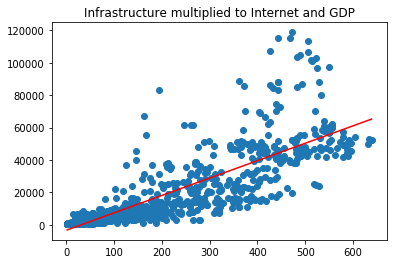

In [37]:
linear_reg(summary[["multiplied"]], gdp[["Value"]], "Infrastructure multiplied to Internet and GDP")

The variance of x is 887.40; and the variance of y is 520061085.89.
The regression coefficient is 607.93; and the intercept is -9494.19.
The correlation coefficient is 0.79, and the correlation of determination r-squared is 0.6306289201423594.


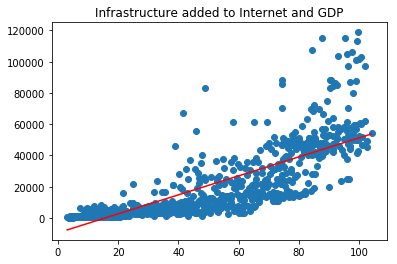

In [38]:
linear_reg(summary[["added"]], gdp[["Value"]], "Infrastructure added to Internet and GDP")

In [39]:
def split_pair_lst(lst):
    inf = [pair[0] for pair in lst]
    gdp = [pair[1] for pair in lst]
    return [inf, gdp]

The variance of x is 26284.70; and the variance of y is 477242211.59.
The regression coefficient is 0.00; and the intercept is 3530.97.
The correlation coefficient is 0.84, and the correlation of determination r-squared is 1.0.


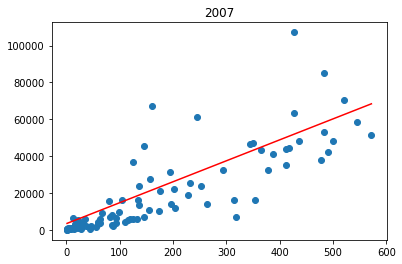

The variance of x is 27599.11; and the variance of y is 556633447.77.
The regression coefficient is 0.00; and the intercept is 4305.77.
The correlation coefficient is 0.83, and the correlation of determination r-squared is 1.0.


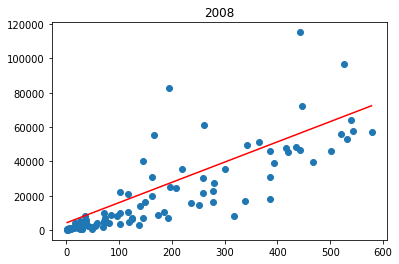

The variance of x is 28349.93; and the variance of y is 421033454.20.
The regression coefficient is 0.00; and the intercept is 4065.37.
The correlation coefficient is 0.85, and the correlation of determination r-squared is 1.0.


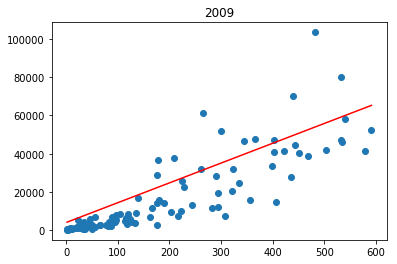

The variance of x is 28875.93; and the variance of y is 458862197.53.
The regression coefficient is 0.00; and the intercept is 4056.06.
The correlation coefficient is 0.85, and the correlation of determination r-squared is 1.0.


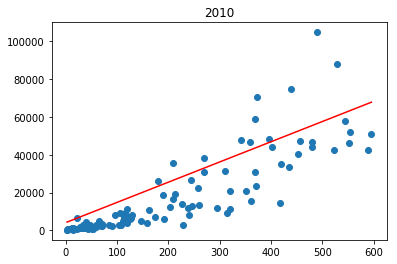

In [40]:
# Plot on the data splitted by year
for i in range(0,4):
    year = i + 2007
    lst = split_pairs_lst_mul[i]
    linear_reg(numpy.array([split_pair_lst(lst)[0]]), numpy.array([split_pair_lst(lst)[1]]), str(year))

The variance of x is 29329.59; and the variance of y is 578643971.87.
The regression coefficient is 0.00; and the intercept is 4404.64.
The correlation coefficient is 0.82, and the correlation of determination r-squared is 1.0.


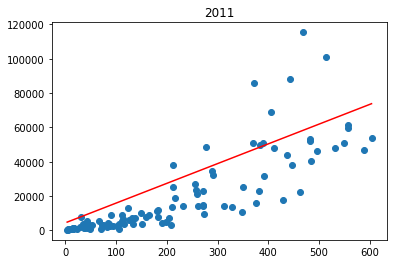

The variance of x is 30114.17; and the variance of y is 546062795.83.
The regression coefficient is 0.00; and the intercept is 4219.05.
The correlation coefficient is 0.80, and the correlation of determination r-squared is 1.0.


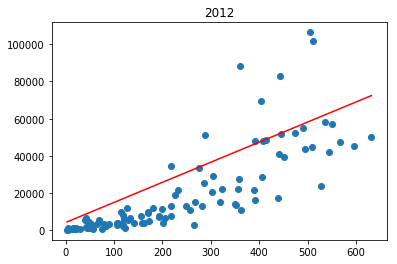

The variance of x is 30929.21; and the variance of y is 570911020.13.
The regression coefficient is 0.00; and the intercept is 4376.97.
The correlation coefficient is 0.81, and the correlation of determination r-squared is 1.0.


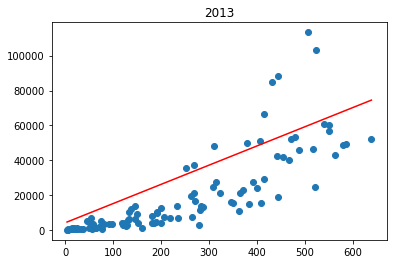

The variance of x is 31198.41; and the variance of y is 575574238.27.
The regression coefficient is 0.00; and the intercept is 4529.02.
The correlation coefficient is 0.80, and the correlation of determination r-squared is 1.0.


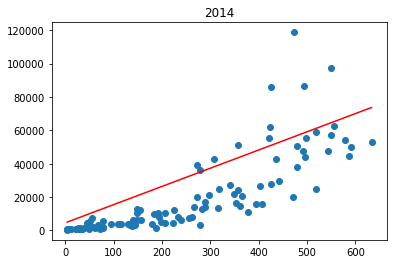

In [41]:
for i in range(4,8):
    year = i + 2007
    lst = split_pairs_lst_mul[i]
    linear_reg(numpy.array([split_pair_lst(lst)[0]]), numpy.array([split_pair_lst(lst)[1]]), str(year))

The variance of x is 786.83; and the variance of y is 477242211.59.
The regression coefficient is 0.00; and the intercept is 3530.97.
The correlation coefficient is 0.84, and the correlation of determination r-squared is 1.0.


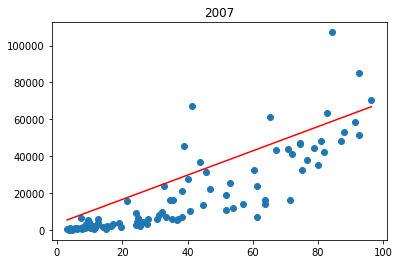

The variance of x is 821.61; and the variance of y is 556633447.77.
The regression coefficient is 0.00; and the intercept is 4305.77.
The correlation coefficient is 0.83, and the correlation of determination r-squared is 1.0.


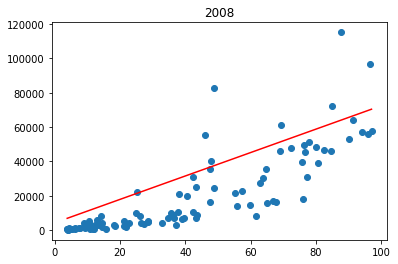

The variance of x is 839.11; and the variance of y is 421033454.20.
The regression coefficient is 0.00; and the intercept is 4065.37.
The correlation coefficient is 0.83, and the correlation of determination r-squared is 1.0.


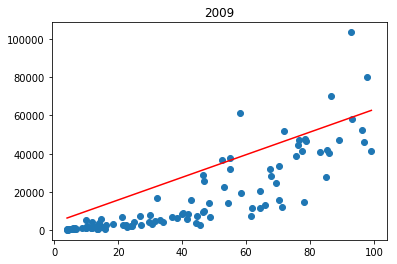

The variance of x is 836.05; and the variance of y is 458862197.53.
The regression coefficient is 0.00; and the intercept is 4056.06.
The correlation coefficient is 0.83, and the correlation of determination r-squared is 1.0.


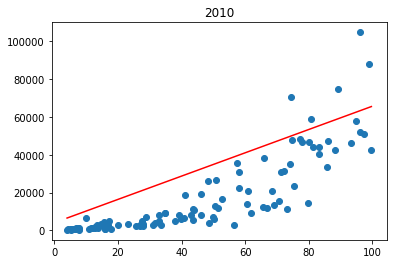

In [42]:
for i in range(0,4):
    year = i + 2007
    lst = split_pairs_lst_add[i]
    linear_reg(numpy.array([split_pair_lst(lst)[0]]), numpy.array([split_pair_lst(lst)[1]]), str(year))

The variance of x is 29329.59; and the variance of y is 578643971.87.
The regression coefficient is 0.00; and the intercept is 4404.64.
The correlation coefficient is 0.82, and the correlation of determination r-squared is 1.0.


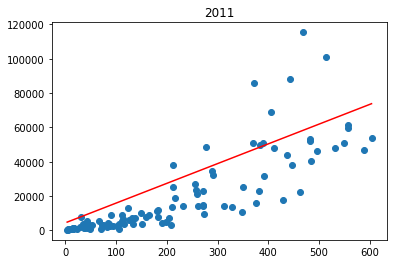

The variance of x is 30114.17; and the variance of y is 546062795.83.
The regression coefficient is 0.00; and the intercept is 4219.05.
The correlation coefficient is 0.80, and the correlation of determination r-squared is 1.0.


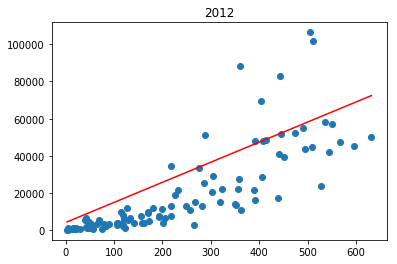

The variance of x is 30929.21; and the variance of y is 570911020.13.
The regression coefficient is 0.00; and the intercept is 4376.97.
The correlation coefficient is 0.81, and the correlation of determination r-squared is 1.0.


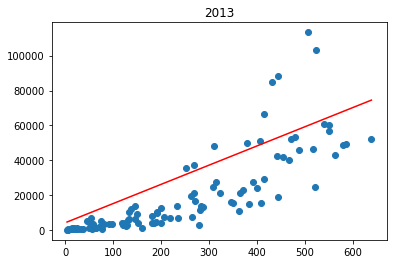

The variance of x is 31198.41; and the variance of y is 575574238.27.
The regression coefficient is 0.00; and the intercept is 4529.02.
The correlation coefficient is 0.80, and the correlation of determination r-squared is 1.0.


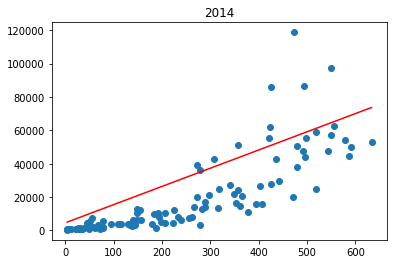

In [43]:
for i in range(4,8):
    year = i + 2007
    lst = split_pairs_lst_mul[i]
    linear_reg(numpy.array([split_pair_lst(lst)[0]]), numpy.array([split_pair_lst(lst)[1]]), str(year))

## Non-linear Regression

In [44]:
# Plot the data with non-linear regession (with Sklearn's LinearRegression package)
## Note: this part of code is derived from code of lecture of April 11
def make_polynomial(x):
    return pandas.DataFrame({"linear": x, "squared": x*x, "cubed": x*x*x})

In [45]:
def non_linear_reg(x, y, lower, upper, title):
    intervals = numpy.linspace(lower, upper, 30)
    model = LinearRegression().fit(make_polynomial(x),y)
    predictions = model.predict(make_polynomial(intervals))
    pyplot.scatter(x, y)
    pyplot.title(title)
    pyplot.plot(intervals, predictions, "r")
    pyplot.show()

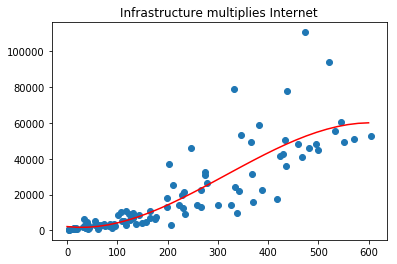

In [46]:
non_linear_reg(inf_groups_mul, gdp_groups, 0, 600, "Infrastructure multiplies Internet")

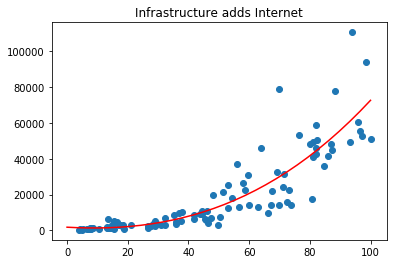

In [47]:
non_linear_reg(inf_groups_add, gdp_groups, 0, 100, "Infrastructure adds Internet")

## Filter by country

In [48]:
# Sort the countries into subgroups, and do regression on them
## Note: this part of code is derived from code of Problem Set 7
style_dummies = pandas.get_dummies(infrastructure["Country or Area"])
style_dummies.head(5)

,Albania,Algeria,Armenia,Australia,Austria,Azerbaijan,Bahrain,Bangladesh,Barbados,Belgium,...,Thailand,Trinidad and Tobago,Turkey,Uganda,Ukraine,United Arab Emirates,United States,Uruguay,Zambia,Zimbabwe
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [49]:
# model
model = LinearRegression().fit(style_dummies.join(infrastructure["Year"]), summary["added"])
country_coef_lst = []
for i in range(0,103):
    country_coef_lst.append(((list(style_dummies)[i], model.coef_[i])))

In [50]:
country_coef_sorted = sorted(country_coef_lst, key=lambda x: x[1])
country_coef_sorted[:5]

[('Burundi', -42.39108535459951),
 ('Chad', -42.060710687474455),
 ('Ethiopia', -41.56657728909954),
 ('Madagascar', -41.20722808259944),
 ('Mali', -39.944547956599564)]

In [51]:
# split the countries into two groups infrastructure quality increase with time
country_large = [tup[0] for tup in country_coef_sorted if tup[1] > 0] #infrastructure quality increase with time
country_small = [tup[0] for tup in country_coef_sorted if tup[1] <= 0] #infrastructure quality does not increase with time
lst_country_lst = [ country_large, country_small]
str_country_lst = ["country_large", "country_small"]

In [52]:
print(country_small)
print(country_large)

['Burundi', 'Chad', 'Ethiopia', 'Madagascar', 'Mali', 'Mozambique', 'Cambodia', 'Burkina Faso', 'Mauritania', 'Bangladesh', 'Lesotho', 'Cameroon', 'Nepal', 'Pakistan', 'Nicaragua', 'Botswana', 'India', 'Zambia', 'Senegal', 'Indonesia', 'Uganda', 'Namibia', 'Algeria', 'Mongolia', 'Guatemala', 'Sri Lanka', 'Honduras', 'Zimbabwe', 'El Salvador', 'Philippines', 'Kenya', 'Egypt', 'Paraguay', 'Thailand', 'Armenia', 'Nigeria', 'Ukraine', 'Guyana', 'South Africa', 'Georgia', 'Mauritius', 'Jamaica', 'Jordan', 'Mexico', 'Peru', 'Kazakhstan', 'Colombia', 'Costa Rica', 'Romania', 'Panama', 'Turkey', 'Azerbaijan', 'Serbia', 'Brazil']
['Albania', 'Montenegro', 'Oman', 'Morocco', 'Bulgaria', 'Saudi Arabia', 'Uruguay', 'Greece', 'Trinidad and Tobago', 'Italy', 'Chile', 'Puerto Rico', 'Portugal', 'Cyprus', 'Croatia', 'Poland', 'Kuwait', 'Malaysia', 'Lithuania', 'Malta', 'Israel', 'Qatar', 'Hungary', 'Slovenia', 'Spain', 'Barbados', 'Bahrain', 'Latvia', 'Ireland', 'Singapore', 'Estonia', 'United Arab Em

In [53]:
def filter_country(df): 
    result = []
    for lst in lst_country_lst:
        result.append(df.loc[df['Country or Area'].isin(lst)])
    return result

In [54]:
infrastructure_groups = pandas.DataFrame(mean_infrastructure_groups).reset_index()
gdp_groups = pandas.DataFrame(mean_gdp_groups).reset_index()
sum_country_lst = filter_country(infrastructure_groups)
gdp_country_lst = filter_country(gdp_groups)

In [55]:
gdp_country_lst[0]["Value"].head()

0     4185.980190
3    58594.062930
4    49142.088741
6    22500.695361
8    15969.302348
Name: Value, dtype: float64

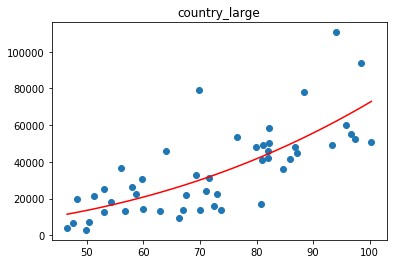

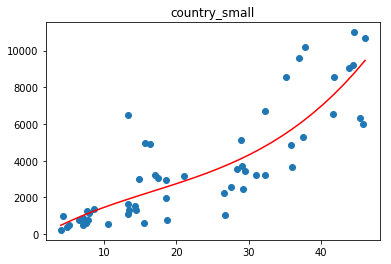

In [56]:
for i in range(2):
    x = sum_country_lst[i]["added"]
    non_linear_reg(x,gdp_country_lst[i]["Value"],x.min(), x.max(), str_country_lst[i])